In [1]:
# Cell 1: Imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import random

/Users/pvishnoi/PycharmProjects/data-etl-ml/venv/lib/python3.9/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
# Cell 2: Transforms
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    # Optional normalization:
    # transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [10]:
# Cell 3: Paths
train_root = '/Users/pvishnoi/PycharmProjects/data-etl-ml/ml/GenAI-Pinnacle-Master/Computer Vision using PyTorch/Module 2/Human Action Recognition/train'
test_root = '/Users/pvishnoi/PycharmProjects/data-etl-ml/ml/GenAI-Pinnacle-Master/Computer Vision using PyTorch/Module 2/Human Action Recognition/test'

In [11]:
# Cell 4: Load full training dataset
full_train_dataset = datasets.ImageFolder(root=train_root, transform=transform)

# Split into train and val (e.g., 80/20 split)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Reverse label map
output_label_map = {v: k for k, v in full_train_dataset.class_to_idx.items()}

In [12]:
output_label_map

{0: 'cycling', 1: 'dancing', 2: 'drinking', 3: 'eating', 4: 'sitting'}

In [13]:
full_train_dataset

Dataset ImageFolder
    Number of datapoints: 3570
    Root location: /Users/pvishnoi/PycharmProjects/data-etl-ml/ml/GenAI-Pinnacle-Master/Computer Vision using PyTorch/Module 2/Human Action Recognition/train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [14]:
# Cell 5: Load test dataset (if labeled like train)
test_dataset = datasets.ImageFolder(root=test_root, transform=transform)

In [15]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 630
    Root location: /Users/pvishnoi/PycharmProjects/data-etl-ml/ml/GenAI-Pinnacle-Master/Computer Vision using PyTorch/Module 2/Human Action Recognition/test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [16]:
# Cell 6: Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
# Cell 7: LeNet-5 Model
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2, 2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
# Cell 8: Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(full_train_dataset.classes)
model = LeNet5(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
# Cell 9: Training Loop
num_epochs = 20
best_accuracy = 0.0
epochs_since_best = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        epochs_since_best = 0
        print(f"✅ New best accuracy: {best_accuracy:.2f}%")
    else:
        epochs_since_best += 1
        if epochs_since_best > 2:
            print("⏹️ Early stopping.")
            break

Epoch 1: 100%|██████████| 90/90 [00:02<00:00, 38.70it/s]


Epoch [1/20] Train Loss: 1.5930, Train Acc: 23.74%, Val Loss: 1.5314, Val Acc: 30.95%
✅ New best accuracy: 30.95%


Epoch 2: 100%|██████████| 90/90 [00:01<00:00, 57.39it/s]


Epoch [2/20] Train Loss: 1.5502, Train Acc: 29.45%, Val Loss: 1.5265, Val Acc: 32.63%
✅ New best accuracy: 32.63%


Epoch 3: 100%|██████████| 90/90 [00:01<00:00, 57.83it/s]


Epoch [3/20] Train Loss: 1.4974, Train Acc: 33.75%, Val Loss: 1.4600, Val Acc: 44.12%
✅ New best accuracy: 44.12%


Epoch 4: 100%|██████████| 90/90 [00:01<00:00, 58.00it/s]


Epoch [4/20] Train Loss: 1.4038, Train Acc: 41.39%, Val Loss: 1.4444, Val Acc: 35.99%


Epoch 5: 100%|██████████| 90/90 [00:01<00:00, 58.37it/s]


Epoch [5/20] Train Loss: 1.3547, Train Acc: 44.05%, Val Loss: 1.3745, Val Acc: 40.76%


Epoch 6: 100%|██████████| 90/90 [00:01<00:00, 58.34it/s]


Epoch [6/20] Train Loss: 1.3105, Train Acc: 47.41%, Val Loss: 1.3766, Val Acc: 43.42%
⏹️ Early stopping.


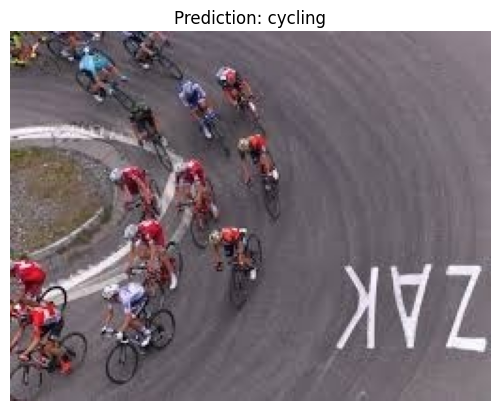

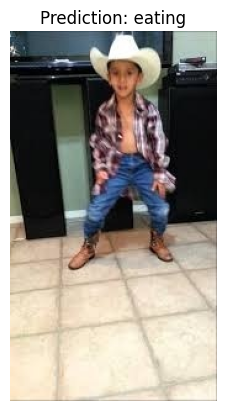

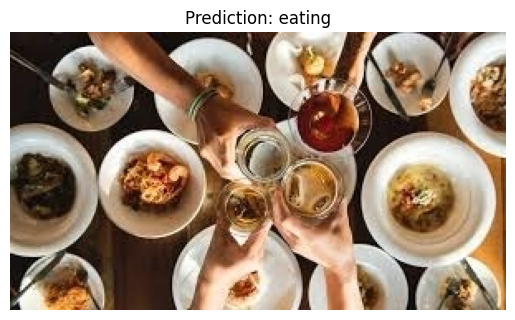

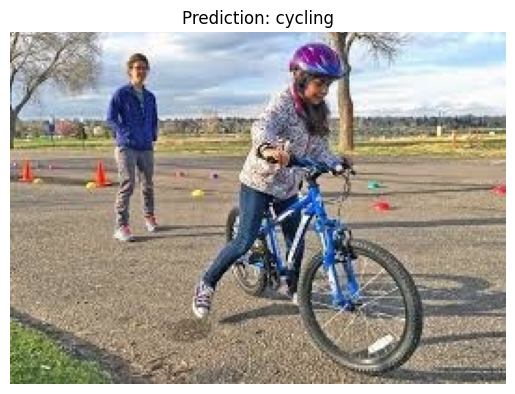

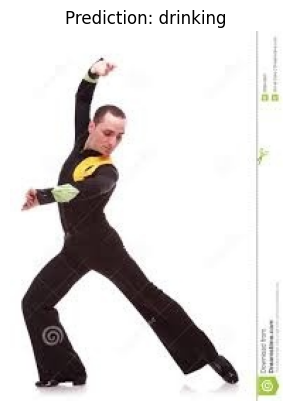

In [20]:
# Cell 10: Inference on test set (random sample)
model.eval()
for i in range(5):
    img_path, label_idx = random.choice(test_dataset.samples)
    image_pil = Image.open(img_path).convert("RGB")
    image = transform(image_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        predicted_class = torch.argmax(output).item()

    plt.imshow(image_pil)
    plt.title(f"Prediction: {output_label_map[predicted_class]}")
    plt.axis("off")
    plt.show()

In [22]:
# ✅ Done!

# This code:
# 	•	Loads images from folders
# 	•	Splits training into train + val
# 	•	Trains LeNet-5
# 	•	Evaluates on val and test sets
# 	•	Shows predictions on test images

# Let me know if your test set has no labels — I can update the inference code accordingly to just predict without comparing to true labels.